In [62]:
%matplotlib inline
from __future__ import division

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

# Ensemble methods
from sklearn.ensemble import RandomForestClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from scipy.stats import uniform

import pydot

In [2]:
# Load json dataset into pandas
data = pd.read_json('train.json', convert_dates=['unix_timestamp_of_request', 'unix_timestamp_of_request_utc'])
test = pd.read_json('test.json', convert_dates=['unix_timestamp_of_request', 'unix_timestamp_of_request_utc'])

In [3]:
data['post_was_edited'] = data['post_was_edited'].map(lambda x: 1 if x > 0 else 0)

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 89 columns):
request_title                                         4040 non-null object
unix_timestamp_of_request                             4040 non-null datetime64[ns]
giver_username_if_known                               4040 non-null object
requester_days_since_first_post_on_raop_at_request    4040 non-null float64
requester_subreddits_at_request                       4040 non-null object
requester_account_age_in_days_at_request              4040 non-null float64
requester_number_of_posts_on_raop_at_request          4040 non-null int64
requester_upvotes_plus_downvotes_at_request           4040 non-null int64
request_text_edit_aware                               4040 non-null object
request_id                                            4040 non-null object
requester_number_of_comments_at_request               4040 non-null int64
requester_number_of_posts_at_request                  4040 no

In [4]:
def remove_train_features():
    data_cols = set(data.columns.values)
    test_cols = set(test.columns.values)
    trim_data_cols = data_cols.intersection(test_cols)
    return list(trim_data_cols)

trim_data_cols = remove_train_features()
trim_data_cols.append('requester_received_pizza') 
data = data[trim_data_cols]

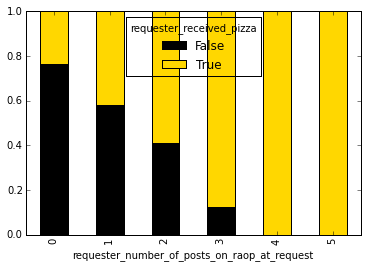

In [5]:
raop_posts = pd.crosstab(data.requester_number_of_posts_on_raop_at_request, data.requester_received_pizza)
raop_posts.div(raop_posts.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True, color=['black', 'gold'], grid=False)

In [6]:
# karma categorical variable, set mid at 175, which is the mean
data['karma_cat_3'] = np.where(data.requester_upvotes_minus_downvotes_at_request <= 0, 0, 
                        np.where((data.requester_upvotes_minus_downvotes_at_request > 0) & 
                        (data.requester_upvotes_minus_downvotes_at_request <=175), 1, 2))
data['karma_cat_2'] = np.where(data.requester_upvotes_minus_downvotes_at_request <= 10, 0, 1)
data['all_text'] = [data.request_title.iloc[[i]].tolist()[0] + ' ' + data.request_text_edit_aware.iloc[[i]].tolist()[0]
                    for i in range(data.shape[0])]

In [7]:
data['number_of_posts_cat'] = np.where(data.requester_number_of_posts_at_request <= 0, 0, 1)

In [8]:
import re
def get_word_counts(word_list):
    entry_count = []
    for entry in data.all_text:
        word_dict = dict((x,0) for x in word_list)
        for word in re.findall(r"\w+", entry):
            if word in word_dict:
                word_dict[word] += 1
        entry_count.append(sum(word_dict.values()))
    return pd.Series(entry_count)
    
job = ['work', 'paycheck', 'unemployment', 'interview', 'fired', 'unemployment', 'hire', 'hired']
money = ['money', 'now', 'broke', 'week', 'until', 'time', 'last', 'day', 'when', 'today', 'tonight', 'paid', 'next', 'first', 'night', 'after', 'tomorrow', 'month', 'while', 'account', 'before', 'long', 'Friday', 'rent', 'buy', 'bank', 'still', 'bills', 'ago', 'cash', 'due', 'past', 'never', 'paycheck', 'check', 'spent', 'years', 'poor', 'till', 'yesterday', 'morning', 'dollars', 'financial', 'hour', 'bill', 'evening', 'credit', 'budget', 'loan', 'bucks', 'deposit', 'dollar', 'current', 'payed']
student = ['college', 'student', 'school', 'roommate', 'studying', 'semester', 'university', 'finals', 'study', 'class', 'project', 'dorm', 'tuition']
family = ['family', 'mom', 'wife', 'wifey', 'parents', 'mother', 'husband', 'dad', 'son', 'daughter', 'father', 'parent', 'mom', 'baby', 'born', 'newborn', 'kid', 'children', 'child']
craving = ['friend', 'girlfriend', 'craving', 'birthday', 'boyfriend', 'celebrate', 'party', 'game', 'games', 'movie', 'date', 'drunk', 'beer', 'celebrating', 'invited', 'drinks', 'crave', 'wasted', 'invite']
gratitude = ['pay', 'forward', 'thank', 'thanks', 'blessed', 'bless', 'grateful', 'reciprocate', 'back', 'teach']
food = ['vegetable', 'vegetables', 'ramen', 'oatmeal']

data['job_c'] = get_word_counts(job)
data['money_c'] = get_word_counts(money)
data['student_c'] = get_word_counts(student)
data['family_c'] = get_word_counts(family)
data['craving_c'] = get_word_counts(craving)
data['gratitude_c'] = get_word_counts(gratitude)
data['food_c'] = get_word_counts(food)
data['exclamation_c'] = map(lambda x: len(re.findall(r'(!)|(:\))', x)), data['all_text'])

In [24]:
# post_length, title length
data['post_length'] = data['request_text_edit_aware'].map(lambda x: len(x))
data['request_title_length'] = data['request_title'].map(lambda x: len(x))
data['link'] = map(lambda x: 1 if x.find('http') > 0 else 0, data['request_text_edit_aware'])
data['img'] = map(lambda x: 1 if x.find('img') > 0 else 0, data['request_text_edit_aware'])
data['link_or_img'] = map(lambda x: 1 if x.find('img') > 0 or x.find('http') > 0 else 0, data['request_text_edit_aware'])

In [10]:
data['job_c_cat'] = np.where(data.job_c == 0, 0, 1)
data['money_c_cat'] = np.where(data.money_c <= 1, 0, 1)

In [39]:
data['weekday'] = map(lambda x: x.weekday(), data['unix_timestamp_of_request'])
data['hour'] = map(lambda x: x.hour, data['unix_timestamp_of_request'])
data['month'] = map(lambda x: x.month, data['unix_timestamp_of_request'])
data['near_midnight'] = map(lambda x: 1 if (x >= 13 and x <= 19) else 0, data['hour'])
# Check near midnight - probably not near midnight

In [46]:
# this doesn't work yet
features_to_encode = ['weekday', 'hour', 'month']

def encode_features(df, fte):
    for feature in fte:
        df = df.join(pd.get_dummies(df[feature], prefix=feature))
    return df

data = encode_features(data, features_to_encode)

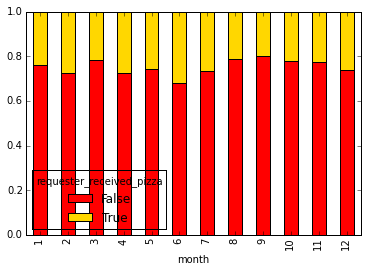

In [45]:
def get_dist(cat):
    crosstab = pd.crosstab(cat, data.requester_received_pizza)
    crosstab.div(crosstab.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True, color=['red','gold'], grid=False)
    
get_dist(data.month)

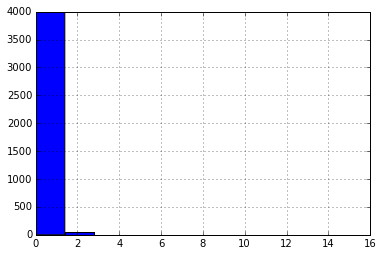

In [14]:
data.food_c.hist()

In [15]:
data['post_length_cat_2'] = np.where(data.post_length <= 180, 0, 1)
data['post_length_cat_3'] = np.where(data.post_length <= 180, 0, np.where((data.post_length > 180) &
                                   (data.post_length <= 502), 1, 2))


In [16]:
data['title_length_cat'] = np.where(data.request_title_length <=45, 0, 1)

In [17]:
import collections
def get_pos_train_text(top_k=10):
    pos_post_text = [data.all_text[i] for i in range(data.shape[1]) if data.requester_received_pizza[i] == 1]
    neg_post_text = [data.all_text[i] for i in range(data.shape[1]) if data.requester_received_pizza[i] == 0]
    cv = CountVectorizer(stop_words='english', max_features=top_k)
    cv.fit_transform(pos_post_text)
    pos_words = collections.OrderedDict(sorted(cv.vocabulary_.items()))
    #print pos_words
    
    cv_neg = CountVectorizer(stop_words='english', max_features=top_k)
    cv_neg.fit_transform(neg_post_text)
    neg_words = collections.OrderedDict(sorted(cv_neg.vocabulary_.items()))
    #print neg_words
    
    pos_words = set(pos_words.keys())
    neg_words = set(neg_words.keys())

    neg_dict = [i for i in neg_words if i not in pos_words]
    pos_dict = [i for i in pos_words if i not in neg_words]
    return pos_dict

pos_dict = get_pos_train_text(30)
print pos_dict

[u'jpg', u'trade', u'blue', u'use', u'make', u'thank', u'pretty', u'forward', u'http', u'friday', u'boyfriend', u'imgur', u'com', u'll', u'scarf']


In [18]:
data['pos_words'] = get_word_counts(pos_dict)
data['pos_words_cat'] = np.where(data.pos_words <= 1, 0, 1)

In [135]:
# Get final data frame and train model
#model_df = data[['karma_cat_2', 'number_of_posts_cat', 'job_c_cat', 'money_c_cat', 
#                'title_length_cat', 'weekday_0', 'weekday_1', 'weekday_2', 'link', 'img',
#                'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'near_midnight', 'pos_words_cat']]

model_df_s = data[['karma_cat_2', 'near_midnight', 'link', 'img', 'gratitude_c',
                   'post_length', 'requester_number_of_posts_on_raop_at_request', 'pos_words',
                   'job_c', 'money_c', 'family_c', 'student_c', 'craving_c', 'request_title_length',
                  'requester_number_of_comments_in_raop_at_request']]
                  
'''
model_df_s = data[['requester_days_since_first_post_on_raop_at_request', 'requester_account_age_in_days_at_request',
                  'requester_number_of_posts_on_raop_at_request', 'requester_upvotes_plus_downvotes_at_request',
                  'requester_number_of_comments_at_request', 'requester_number_of_posts_at_request', 
                  'requester_number_of_subreddits_at_request', 'requester_upvotes_minus_downvotes_at_request',
                  'requester_number_of_comments_in_raop_at_request', 'near_midnight', 'link', 'img',
                  'post_length', 'job_c', 'money_c', 'family_c', 'student_c', 'craving_c', 'request_title_length',
                  'karma_cat_2', 'post_length_cat_2', 'number_of_posts_cat', 'gratitude_c]]
'''

scaler = scalar = preprocessing.StandardScaler()
scaler.fit(model_df_s.values)
model_df = scalar.transform(model_df_s.values)

np.random.seed(0)
shuffle = np.random.permutation(np.arange(data.shape[0]))

# Pull out text features
train_length = 3230
data_mat, labels = model_df[shuffle], data.requester_received_pizza.values[shuffle]

data_shuffle = pd.DataFrame(data, index=shuffle)
train_data, train_labels = data_mat[:train_length], labels[:train_length]
dev_data, dev_labels = data_mat[train_length:], labels[train_length:]
print train_data[10:20]

[[  6.55811326e-01   1.77903020e+00  -2.69733646e-01  -2.05697986e-01
   -6.18162365e-01   1.13132232e+00  -1.95294674e-01  -6.23184789e-01
   -4.55484057e-01   1.16183455e+00   4.14114466e+00  -4.59017360e-01
   -4.31870465e-01  -5.78137062e-01  -1.88976157e-01]
 [ -1.52482880e+00  -5.62104005e-01  -2.69733646e-01  -2.05697986e-01
    1.11552452e+00   4.57864207e-01  -1.95294674e-01   1.15023612e+00
   -4.55484057e-01   2.85563662e-02  -4.32204098e-01  -4.59017360e-01
   -4.31870465e-01   2.77996597e-03  -1.88976157e-01]
 [  6.55811326e-01  -5.62104005e-01  -2.69733646e-01  -2.05697986e-01
   -6.18162365e-01   4.41303762e-01  -1.95294674e-01  -3.20444867e-02
   -4.55484057e-01  -8.78066183e-01  -4.32204098e-01  -4.59017360e-01
   -4.31870465e-01  -3.01509906e-01  -1.88976157e-01]
 [  6.55811326e-01  -5.62104005e-01  -2.69733646e-01  -2.05697986e-01
    2.48681076e-01   4.10929965e-02  -1.95294674e-01  -6.23184789e-01
   -4.55484057e-01   1.16183455e+00  -4.32204098e-01   5.28958204e-0

In [104]:
def run_knn(train, dev):
    
    def get_best_k(k_values):
        accuracies = []
        best_k = 1
        best_recall = 0
        for i in k_values:
            neigh = KNeighborsClassifier(n_neighbors=i)
            neigh.fit(train, train_labels)
            pred = neigh.predict(dev)
            recall_score = metrics.recall_score(pred, dev_labels)
            if recall_score > best_recall:
                best_k = i
                best_recall = recall_score
        return best_k

    
    def knn(best_k):
        neigh = KNeighborsClassifier(n_neighbors=best_k)
        neigh.fit(train, train_labels)
        pred = neigh.predict(dev)
        print "Accuracy: {}".format(neigh.score(dev, dev_labels))
        print classification_report(pred, dev_labels)
        return neigh

    k_values = np.arange(1,20,1)
    best_k = get_best_k(k_values)
    print best_k
    pred = knn(best_k)
    return pred
knn = run_knn(train_data, dev_data)

18
Accuracy: 0.754320987654
             precision    recall  f1-score   support

      False       0.99      0.76      0.86       799
       True       0.03      0.64      0.07        11

avg / total       0.98      0.75      0.85       810



In [105]:
def log_reg(train, dev, param_grid):
    logreg = LogisticRegression()
    logreg = GridSearchCV(logreg, param_grid, scoring='roc_auc', verbose=True, cv=5)
    logreg.fit(train, train_labels)
    print("Best C: {}, with and accuracy of: {}".format(logreg.best_params_, logreg.best_score_))
    pred = logreg.predict(dev)
    print classification_report(pred, dev_labels)
    return logreg
    
param_grid = [{'C': np.arange(.1, 1, .1), 'penalty': ['l1', 'l2']}]
logreg = log_reg(train_data, dev_data, param_grid)
print 1 - sum(dev_labels.astype(float))/len(dev_labels.astype(float))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.6s


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best C: {'penalty': 'l1', 'C': 0.20000000000000001}, with and accuracy of: 0.662493768855
             precision    recall  f1-score   support

      False       0.98      0.77      0.86       776
       True       0.10      0.59      0.17        34

avg / total       0.94      0.76      0.83       810

0.750617283951


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.0s finished


In [132]:
def ada_boost():
    
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=290)
    scores = cross_val_score(clf, train_data, train_labels)
    print scores
    clf.fit(train_data, train_labels)
    pred = clf.predict(dev_data)
    print clf.score(dev_data, dev_labels)
    print classification_report(pred, dev_labels)

    cm = confusion_matrix(dev_labels, pred)
    print(cm)
    
    for i in range(len(pred)):
        if pred[i] == 0 and dev_labels[i] == 1:
            #print data_shuffle.all_text.iloc[[i]].tolist()[0]
            pass
    return clf

    
ada = ada_boost()

[ 0.75023213  0.7455896   0.74070632]
0.771604938272
             precision    recall  f1-score   support

      False       0.97      0.78      0.86       753
       True       0.18      0.65      0.29        57

avg / total       0.91      0.77      0.82       810

[[588  20]
 [165  37]]


In [107]:
def get_svc():
    svc_params = {"C": uniform(), "gamma": uniform(), "kernel": ['linear', 'rbf'],
                  "class_weight": [{1: 1}, {1: 2}, {1: 5}, {1: 10}], "probability": [True] }
    svc = RandomizedSearchCV(SVC(), param_distributions=svc_params, n_iter=10)
    svc.fit(train_data, train_labels)
    preds = svc.predict(dev_data)
    print svc.score(dev_data, dev_labels)
    print classification_report(preds, dev_labels)
    return svc


svc = get_svc()

0.753086419753
             precision    recall  f1-score   support

      False       0.99      0.76      0.86       798
       True       0.03      0.58      0.07        12

avg / total       0.98      0.75      0.85       810



In [31]:
final_pred = []
for i in range(len(ada_pred)):
    new_pred = 1.0*(int(ada_pred[i]) + int(knn_pred[i]) + int(logreg_pred[i]))/3
    if new_pred > .10:
        final_pred.append(True)
    else:
        final_pred.append(False)

correct = 0
total = 0
for j in range(len(final_pred)):
    if final_pred[j] == dev_labels[j]:
        correct += 1
    total += 1
print 1.0 * correct / total

NameError: name 'ada_pred' is not defined

In [79]:
def bagging():
    bagging = BaggingClassifier(AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, min_samples_leaf=1), n_estimators=300, algorithm="SAMME"), 
                               max_samples=.5, max_features=.5)
    scores = cross_val_score(bagging, train_data, train_labels)
    bagging.fit(train_data, train_labels)
    pred = bagging.predict(dev_data)
    print bagging.score(dev_data, dev_labels)
    print classification_report(pred, dev_labels)

    cm = confusion_matrix(dev_labels, pred)
    print(cm)
    
    
bagging()

0.753086419753
             precision    recall  f1-score   support

      False       1.00      0.75      0.86       804
       True       0.02      0.67      0.04         6

avg / total       0.99      0.75      0.85       810

[[606   2]
 [198   4]]


In [115]:
ada_pred = ada.predict(dev_data)
ada_proba = ada.predict_proba(dev_data)
svc_pred = svc.best_estimator_.predict(dev_data)
svc_proba = svc.best_estimator_.predict_proba(dev_data)
knn_pred = knn.predict(dev_data)
logreg_proba_ = logreg.best_estimator_.predict_proba(dev_data)

final_preds = []
for i in range(len(ada_pred)):
    if (ada_pred[i] != svc_pred[i] and ada_pred[i] != logreg_pred[i]):
        final_preds.append(svc_pred[i])
        #print ada_pred[i] == dev_labels[i]
    else:
        final_preds.append(ada_pred[i])

def get_accuracy(final_preds):
    correct = 0
    total = 0
    for j in range(len(final_preds)):
        if final_preds[j] == dev_labels[j]:
            correct += 1
        total += 1
    print 1.0 * correct / total 
        #print("Predict 1, but actually 0")
        #print svc.best_estimator_.predict_proba(dev_data)[i]
        #print ada.predict_proba(dev_data)[i]
        #print logreg.best_estimator_.predict_proba(dev_data)[i]

#print ada_proba[:,1]
adj_preds = map(lambda x: 1 if x >= .5 else 0, svc_proba[:,1])
print classification_report(adj_preds, dev_labels)
get_accuracy(adj_preds)

             precision    recall  f1-score   support

          0       0.99      0.76      0.86       798
          1       0.03      0.58      0.07        12

avg / total       0.98      0.75      0.85       810

0.753086419753


In [183]:
model_df_s = data[['karma_cat_2', 'near_midnight', 'link', 'img', 'gratitude_c',
                   'post_length', 'requester_number_of_posts_on_raop_at_request', 'pos_words',
                   'job_c', 'money_c', 'family_c', 'student_c', 'craving_c', 'request_title_length',
                  'requester_number_of_comments_in_raop_at_request']]